### Data Description and Explorative Data Analysis
Novielli et al. [1] created a gold standard data set from GitHub data, which includes 7122 data points in total.
Each data point contains a ID column, a text column and a column, containing one of the three polarity classes („neutral“, „positive“, „negative“).
The data points were labeled by 3 independent raters, for the most part, using the Shaver et al. [2] emotion framework.<br>
Eventually the polarity classess „positive“, or „negative“ were assigned to the data points, respectively „neutral“, if neither „positive“ or „negative“ was assigned.<br>
The dataset is fairly well balanced, with 29% negative labels, 28 % positive labels and 43 % neutral labels.<br>
It’s worth mentioning that natural text, especially in the software engineering jargon, is more often absent from sentiment, than it expresses sentiment.
Therefore a truly even distribution of the polarity clases (33% positive, 33 % neutral, 33% negative), would probably not be beneficial.<br>
The GitHub dataset was created using an iterative approach:<br>
1. From a GitHub dataset of 116k documents, 4k documents were randomly selected and manually annotated by three raters.
They decided by majority which polarity class should be assigned to which document.
Duplicates and documents for which the raters could not assign a polarity class by majority vote were removed, adding 3931 documents to the gold standard data set.
2. Since there was an excess of neutral comments (77%), more positive and negative documents should be added to the dataset.
To save time, the Senti4SD classifier was trained with the approx. 4k documents from the first step in order to automatically classify the remaining 112k documents.
From this, 600 positively and 600 negatively evaluated documents were selected at random and the majority of the evaluators had to agree on whether they agreed with the classification of Senti4SD or not. Ultimately, 343 more positive and 550 negative comments were added to the gold standard dataset.
3. In the third step, the classifier was trained again, this time with the data set obtained from step 2..
With the same procedure as in step 2., another 1124 positively classified documents and 1204 negatively classified documents could be added to the gold standard dataset.
The result is a gold standard data set with 7122 comments. The iterative approach is also appended in graphic 1.

The data is imported and some core statistics are printed and visualized.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

f_path = os.path.abspath('')
data = pd.read_csv(os.path.join(f_path, 'data/github_gold.csv'), delimiter=';')

data.shape

(7122, 3)

There is a redundant 'ID' column as well as a polarity and a text column. Let's get rid of the id column.

In [2]:
data.drop(columns='ID', inplace=True)
data.head(n=10)

,Polarity,Text
0,neutral,No. I still see the wrong twins. * https://gi...
1,neutral,"Reverted."""
2,neutral,You can leave a queue while in queue ? (before...
3,positive,"Didn't look at SpellTargetRestrictions XD"""
4,neutral,Not sure about what kind of line lengths the p...
5,positive,@normanmaurer Nice catch ! Did you make the sa...
6,neutral,That's why I didn't close after sending the cl...
7,neutral,Build result for 78d8f05c218cab107255c4dc1a134...
8,neutral,Why you think using ImmediateEventExecutor is ...
9,neutral,These are the ones we currently hardcode in Te...


The visualization of the distribution of the polarity classes is follwing.

/var/folders/l4/49sqz_0968dgz95nxsm709yw0000gn/T/ipykernel_5319/1334325380.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


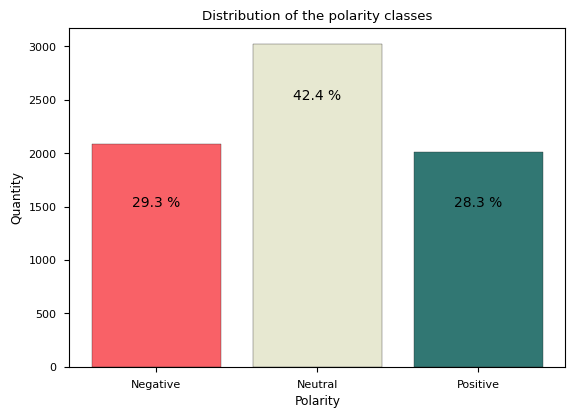

In [3]:
neutral, negative, positive = data['Polarity'].value_counts()

plt.style.use('seaborn-paper')
fig, ax = plt.subplots()

ax.bar(x='Negative', height = negative, color='#F96167', edgecolor='#201E20')
ax.text(x ='Negative' , y=1500, s='{perc:.1f} %'.format(perc= negative / (negative + neutral + positive)*100), horizontalalignment='center')

ax.bar(x='Neutral', height = neutral, color='#E7E8D1', edgecolor='#201E20')
ax.text(x = 'Neutral', y=2500, s='{perc:.1f} %'.format(perc= neutral / (negative + neutral + positive)*100), horizontalalignment='center')

ax.bar(x='Positive', height = positive, color='#317773', edgecolor='#201E20')
ax.text(x = 'Positive', y=1500, s='{perc:.1f} %'.format(perc= positive / (negative + neutral + positive)*100), horizontalalignment='center')

ax.set(xlabel='Polarity', 
       ylabel='Quantity',
       title='Distribution of the polarity classes')

plt.show()

### Feature Engineering
Text data contains a lot of noise which makes the sentiment analysis task hard to complete. <br>
Therefore I'm defining a couple of functions, which can be tuned as hyperparameter of the model, that help to get rid of some noise.


#### Clean Up

In [4]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

def remove_punctuation(text):
    # Removes special characters
    regular_punct = list(string.punctuation)
    for punc in regular_punct:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip().lower()


def remove_stopwords(text):
    # Removes the most common english words, like 'a', 'the', etc.
    en_stops = set(stopwords.words('english'))
    text = text.split()
    text = " ".join([word for word in text if not word in en_stops])  
    return text

prcsd_data = data.copy(deep=True)

print('The text column after removing punctation:')
prcsd_data['Text'] = prcsd_data['Text'].apply(remove_punctuation)
print(prcsd_data['Text'])
print()

print('The text column after removing stopwords:')
prcsd_data['Text'] = prcsd_data['Text'].apply(remove_stopwords)
print(prcsd_data['Text'])

[nltk_data] Downloading package punkt to /Users/timo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/timo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/timo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/timo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The text column after removing punctation:
0       no  i still see the wrong twins     https   gi...
1                                                reverted
2       you can leave a queue while in queue    before...
3               didn t look at spelltargetrestrictions xd
4       not sure about what kind of line lengths the p...
                              ...                        
7117    yeah  i m capable of working around it   a set...
7118    looks fine to me   on jul 8  2013  at 10 12 pm...
7119    formula updated to address this  would be nice...
7120                                          i trust you
7121    got it  thanks   on sat  mar 31  2012 at 2 07 ...
Name: Text, Length: 7122, dtype: object

The text column after removing stopwords:
0       still see wrong twins https github com mojombo...
1                                                reverted
2                      leave queue queue needconfirmation
3                         look spelltargetrestrictions xd
4   

#### Tokenizer

In [5]:
# I'm using the tokenizer included in the nltk package
print('The text column after tokenizing:')
prcsd_data['Text'] = prcsd_data['Text'].apply(word_tokenize)
print(prcsd_data['Text'])

The text column after tokenizing:
0       [still, see, wrong, twins, https, github, com,...
1                                              [reverted]
2                 [leave, queue, queue, needconfirmation]
3                     [look, spelltargetrestrictions, xd]
4       [sure, kind, line, lengths, project, adheres, ...
                              ...                        
7117    [yeah, capable, working, around, setting, disa...
7118    [looks, fine, jul, 8, 2013, 10, 12, pm, joshua...
7119    [formula, updated, address, would, nice, brew,...
7120                                              [trust]
7121    [got, thanks, sat, mar, 31, 2012, 2, 07, jack,...
Name: Text, Length: 7122, dtype: object


### Lemmatizer

In [6]:
def lemmatizer(text):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(w) for w in text]

print('The text column after lemmatizing:')
prcsd_data['Text'] = prcsd_data['Text'].apply(lemmatizer)
print(prcsd_data['Text'])

The text column after lemmatizing:
0       [still, see, wrong, twin, http, github, com, m...
1                                              [reverted]
2                 [leave, queue, queue, needconfirmation]
3                     [look, spelltargetrestrictions, xd]
4       [sure, kind, line, length, project, adheres, d...
                              ...                        
7117    [yeah, capable, working, around, setting, disa...
7118    [look, fine, jul, 8, 2013, 10, 12, pm, joshua,...
7119    [formula, updated, address, would, nice, brew,...
7120                                              [trust]
7121    [got, thanks, sat, mar, 31, 2012, 2, 07, jack,...
Name: Text, Length: 7122, dtype: object


### Vectorizing

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def combine_text(input):
    combined = ' '.join(input)
    return combined

# Bag of Words
bow = CountVectorizer(ngram_range=(1, 1))
X_bow = bow.fit_transform(prcsd_data['Text'].values.tolist()).toarray()

# Bigram BoW
bbow = CountVectorizer(ngram_range=(2, 2))
X_bbow = bbow.fit_transform(prcsd_data['Text'].values.tolist())

# Term-Frequency-Inverse-Document-Frequency
tfidf = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(prcsd_data['Text'].values.tolist())

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
print(prcsd_data['Text'].values.tolist())
print(data['Text'].values.tolist())

In [ ]:
print(len(bow.get_feature_names_out()))

print(len(bbow.get_feature_names_out()))

print(len(tfidf.get_feature_names_out()))


In [ ]:
# Define different data with different preprocessing techniques

data2 = data.copy(deep=True)
data2['Text'] = data2['Text'].apply(remove_punctuation)
data2['Text'] = data2['Text'].apply(remove_stopwords)

data3 = data.copy(deep=True)
data3['Text'] = data3['Text'].apply(remove_punctuation)
data3['Text'] = data3['Text'].apply(word_tokenize)
data3['Text'] = data3['Text'].apply(combine_text)

data4 = data.copy(deep=True)
data4['Text'] = data4['Text'].apply(remove_punctuation)
data4['Text'] = data4['Text'].apply(word_tokenize)
data4['Text'] = data4['Text'].apply(lemmatizer)
data4['Text'] = data4['Text'].apply(combine_text)

# Vectorize each dataset
# Bag of Words
bow0 = CountVectorizer(ngram_range=(1, 1))
X_bow0 = bow0.fit_transform(data['Text'].values.tolist())

bow2 = CountVectorizer(ngram_range=(1, 1))
X_bow2 = bow2.fit_transform(data2['Text'].values.tolist())

bow3 = CountVectorizer(ngram_range=(1, 1))
X_bow3 = bow3.fit_transform(data3['Text'].values.tolist())

bow4 = CountVectorizer(ngram_range=(1, 1))
X_bow4 = bow4.fit_transform(data4['Text'].values.tolist())

# Bigram BoW
bbow0 = CountVectorizer(ngram_range=(2, 2))
X_bbo0 = bbow0.fit_transform(data['Text'].values.tolist())

bbow2 = CountVectorizer(ngram_range=(2, 2))
X_bbo2 = bbow2.fit_transform(data2['Text'].values.tolist())

bbow3 = CountVectorizer(ngram_range=(2, 2))
X_bbo3 = bbow3.fit_transform(data3['Text'].values.tolist())

bbow4 = CountVectorizer(ngram_range=(2, 2))
X_bbo4 = bbow4.fit_transform(data4['Text'].values.tolist())

# Term-Frequency-Inverse-Document-Frequency
tfidf0 = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
X_tfidf0 = tfidf0.fit_transform(data['Text'].values.tolist())

tfidf2 = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
X_tfidf2 = tfidf2.fit_transform(data2['Text'].values.tolist())

tfidf3 = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
X_tfidf3 = tfidf3.fit_transform(data3['Text'].values.tolist())

tfidf4 = TfidfVectorizer(use_idf = True, ngram_range=(1, 1))
X_tfidf4 = tfidf4.fit_transform(data4['Text'].values.tolist())


### Visualization of the features
In the first bar, no preprocessing is performed at all. That bar is just an object of comparison.
In the other cases, text is always converted to lower case and special characters are also always removed, because that's best practice in almost every NLP task.
Let's plot how the other preprocessing tasks influence the number of features.

In [ ]:
features_raw = len(bow0.get_feature_names_out())
features_tokenize = len(bow3.get_feature_names_out())
features_stopwords = len(bow2.get_feature_names_out())
features_lemmatize = len(bow4.get_feature_names_out())
features_all = len(bow.get_feature_names_out())

plt.style.use('seaborn-paper')
fig, ax = plt.subplots()

ax.bar(x='Raw data', height = features_raw, color='#317773', edgecolor='#201E20')
ax.text(x ='Raw data' , y=6000, s=str(features_raw), horizontalalignment='center')

ax.bar(x='Tokenize', height = features_tokenize, color='#317773', edgecolor='#201E20')
ax.text(x = 'Tokenize', y=6000, s=str(features_tokenize), horizontalalignment='center')

ax.bar(x='Remove stopwords', height = features_stopwords, color='#317773', edgecolor='#201E20')
ax.text(x = 'Remove stopwords', y=6000, s=str(features_stopwords), horizontalalignment='center')

ax.bar(x='Lemmatize', height = features_lemmatize, color='#317773', edgecolor='#201E20')
ax.text(x = 'Lemmatize', y=6000, s=str(features_lemmatize), horizontalalignment='center')

ax.bar(x='All previous', height = features_all, color='#317773', edgecolor='#201E20')
ax.text(x = 'All previous', y=6000, s=str(features_all), horizontalalignment='center')

ax.set(xlabel='Preprocessing task', 
       ylabel='Features Quantity',
       title='Distribution of features')

plt.show()

In [ ]:
"""
X = X_tfidf.todense() # Just tfidf, because training time is otherweise too long on my local pc.
Y = prcsd_data['Polarity'].map({'negative': -1, 'neutral': 0, 'positive': 1})

print(type(X))
print('X_train shape:', X.shape)
print()
print(type(Y))
print('Y_test shape:', Y.shape)

X
"""

### Deep Learning Model
Now let's train a deep learning model, using the different hyperparameters, and let's evaluate the performance.

In [8]:
# Other hyperparameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV

# not used atm
text_vectorizer = TextVectorization(max_tokens=None, 
                                    #already done
                                    standardize=None,
                                    #whitespace delimiter
                                    split="whitespace", 
                                    #dont group anything, every token alone
                                    ngrams = None, 
                                    output_mode ="int",
                                    #length of each sentence == length of largest sentence
                                    output_sequence_length=None
                                    )

X = X_bow # Just tfidf, because training time is otherweise too long on my local pc.
Y = prcsd_data['Polarity'].map({'negative': -1, 'neutral': 0, 'positive': 1})

prcsd_data['Polarity'] = prcsd_data['Polarity'].map({'negative': -1, 'neutral': 0, 'positive': 1})
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

Y_train = to_categorical(Y_train, 3)
Y_test = to_categorical(Y_test, 3)

model = Sequential()
#model.add(text_vectorizer)
model.add(Embedding(input_dim=100, output_dim=300, input_length=11320))
model.add(GRU(128, dropout=0.2))
model.add(Dense(3, activation='softmax'))

NameError: name 'X_bow' is not defined

In [ ]:
print(type(X_train))
print(X_train[:10])
print()
print(type(X_test))
print(X_test[:10])
print()
print(type(Y_train))
print(Y_train[:10])
print()
print(type(Y_test))
print(Y_test[:10])

In [ ]:
X_train.shape

In [ ]:
# Compiling the model and predicting the sentiment
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=256, epochs=5)
score = model.evaluate(X_test, Y_test)

print(score)

In [ ]:
from matplotlib.ticker import MaxNLocator
accuracies = [0.7222, 0.8763, 0.9275, 0.9276, 0.9279]

fig, ax = plt.subplots()

ax.plot([1, 2, 3, 4, 5], accuracies)

ax.set(xlabel='Epoch', 
       ylabel='Accuracy',
       title='Accuracy per Epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
